In [2]:
# Standard Library
import os
import time
import re
import json
import gzip
import shutil
import tarfile
import subprocess
from pathlib import Path
from typing import TypedDict, List, Dict, Any
from urllib.parse import urljoin, urlparse, parse_qs, unquote

# Third-Party Libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from openai import OpenAI
from IPython.display import display, Markdown
from geofetch import Geofetcher

# Bioinformatics
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# LangChain/LangGraph
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda

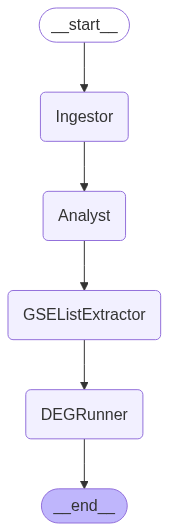

In [16]:
client = OpenAI()
class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: list
    research_plan: str
    selected_gse: str  # ⬅️ now added
    selected_gses: List[str]  # ✅ new field for multiple GSEs
    deg_results: Dict[str, str]  # ✅ map GSE → output CSV path

# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)

def extract_gse_from_research_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    match = re.search(r"GSE\d{5,}", plan)
    if match:
        selected_gse = match.group(0)
        print(f"🔍 Extracted GSE ID: {selected_gse}")
        return {**state, "selected_gse": selected_gse}
    else:
        print("⚠️ No GSE ID found in research plan.")
        return state

# LangGraph node: Extract GSEs from research plan and update state
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# ----------------------------------------
# Utility functions (LLM + GEO search)
# ----------------------------------------

def extract_json_block(text):
    match = re.search(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    else:
        return json.loads(text)


def extract_json_block(text: str) -> dict:
    """
    Extract and parse the first JSON block from LLM output, with fallback and error reporting.
    """
    import json
    import re

    try:
        match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
        if match:
            return json.loads(match.group(1))
        return json.loads(text)  # fallback if no block match
    except json.JSONDecodeError as e:
        print("⚠️ JSON decode error:", e)
        print("🔍 Raw content:\n", text[:1000])  # preview
        raise




def generate_pathway_info(query_gene, model="gpt-4o-mini", temperature=0.3):
    prompt = f"""
You are a biomedical assistant.

Given the gene {query_gene}, return:
1. Key gene symbols in the same biological pathway.
2. Drugs or compounds that inhibit this pathway or {query_gene}'s activity.
3. The disease areas or biological processes this pathway is involved in.

Provide answers in JSON format with keys: "genes", "drugs", "pathways"
    """
    completion = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    content = completion.choices[0].message.content
    return extract_json_block(content)



def scrape_organism_from_geo_html(geo_accession):
    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo_accession}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        organism_row = soup.find("td", string="Organism")
        if organism_row and organism_row.find_next_sibling("td"):
            return organism_row.find_next_sibling("td").text.strip()
    except Exception as e:
        print(f"⚠️ Failed to scrape organism for {geo_accession}: {e}")
    return "Unknown"

def search_geo_datasets(keyword, retmax=10):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "gds",
        "term": keyword,
        "retmode": "json",
        "retmax": retmax
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json().get("esearchresult", {}).get("idlist", [])

def fetch_gse_accessions(id_list):
    if not id_list:
        return {}
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    params = {
        "db": "gds",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    summaries = response.json().get("result", {})
    summaries.pop("uids", None)
    gse_dict = {}
    for uid, info in summaries.items():
        accession = info.get("accession")
        title = info.get("title")
        link = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={accession}"
        organism = scrape_organism_from_geo_html(accession)
        gse_dict[accession] = {
            "title": title,
            "organism": organism,
            "link": link
        }
    return gse_dict

def search_geo_items(item_list, label="gene", max_results=5):
    results = {}
    for item in item_list:
        query = f"{item} AND rna-seq"
        print(f"🔍 Searching GEO for {label}: {item}")
        ids = search_geo_datasets(query, retmax=max_results)
        datasets = fetch_gse_accessions(ids)
        results[item] = datasets
        time.sleep(0.3)
    return results

def get_geofetch_projects(gse_list, metadata_folder="geofetch_metadata"):
    geof = Geofetcher(
        processed=True,
        acc_anno=True,
        discard_soft=True,
        metadata_folder=metadata_folder
    )
    projects = {}
    for gse in gse_list:
        try:
            print(f"📥 Fetching metadata for {gse}")
            result = geof.get_projects(gse)
            projects.update(result)
        except Exception as e:
            print(f"❌ Failed to fetch {gse}: {e}")
    return projects

import subprocess
def download_processed_files_via_cli(gse_list, output_dir="geofetch_metadata", overwrite=False):
    for gse in gse_list:
        gse_path = os.path.join(output_dir, gse)
        if os.path.exists(gse_path) and not overwrite:
            print(f"✅ {gse}: already exists at {gse_path}, skipping.")
            continue
        try:
            subprocess.run(
                ["geofetch", "-i", gse, "--processed", "-m", output_dir],
                check=True
            )
            print(f"✅ Finished downloading for {gse}")
        except subprocess.CalledProcessError as e:
            print(f"❌ geofetch failed for {gse}: {e}")

def save_combined_metadata_csv_from_state(state: Dict, csv_path: str = "geofetch_metadata/combined_metadata.csv") -> pd.DataFrame:
    metadata = state.get("metadata", {})
    if not metadata:
        raise ValueError("No metadata found in the agent state.")

    all_dfs = []
    for gse, project in metadata.items():
        try:
            df = project.sample_table.copy()
            df["source_gse"] = gse
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Failed to extract sample_table from {gse}: {e}")

    if not all_dfs:
        raise ValueError("No sample tables to save.")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    combined_df.to_csv(csv_path, index=False)
    print(f"✅ Combined metadata saved to: {os.path.abspath(csv_path)}")
    return combined_df





def scrape_geo_supplementary_downloads(gse_id: str):
    """
    Scrape the GEO page for a given GSE ID and return a list of supplementary
    files that are .tar, .gz, or .tar.gz.

    Returns:
        List of tuples: (file_name, download_url)
    """
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"
    print(f"🔍 Scraping GEO page: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()
        print("✅ Page fetched successfully")

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")
        print(f"🔎 Found {len(tables)} total tables")

        for idx, table in enumerate(tables):
            if "Supplementary file" in table.text:
                print(f"📋 Found supplementary file table at index {idx}")
                rows = table.find_all("tr")
                print(f"📄 Table has {len(rows) - 1} data rows")

                files = []

                for row in rows[1:]:  # skip header
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        link_tag = cols[2].find("a", href=True)

                        if link_tag:
                            href = link_tag["href"]

                            # Only include valid file extensions
                            if file_name.endswith((".tar", ".gz", ".tar.gz")):
                                if href.startswith("/geo/download"):
                                    full_link = urljoin(base_url, href)
                                    files.append((file_name, full_link))
                                elif href.startswith("ftp://") or href.startswith("http://") or href.startswith("https://"):
                                    files.append((file_name, href))

                if files:
                    return files
                else:
                    print("⚠️ Found table, but no matching .tar/.gz files.")
                    return []

        print("⚠️ No supplementary file table found.")
        return []

    except Exception as e:
        print(f"❌ Error: {e}")
        return []


def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    # ----------------------------------------
    # Download each GSE using embedded logic
    # ----------------------------------------
    base_dir = Path("rna_seq_analysis")
    for gse_id in all_gse:
        download_dir = base_dir / gse_id

        if download_dir.exists() and any(download_dir.iterdir()):
            print(f"📁 Skipping {gse_id}: folder already exists.")
            continue

        download_dir.mkdir(parents=True, exist_ok=True)
        files = scrape_geo_supplementary_downloads(gse_id)
        if not files:
            print(f"⚠️ No supplementary files found for {gse_id}")
            continue

        file_name, url = files[0]
        if not file_name:
            parsed = urlparse(url)
            qs = parse_qs(parsed.query)
            file_name = unquote(qs.get("file", ["unnamed_file"])[0])

        file_path = download_dir / file_name
        print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

        try:
            subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        except subprocess.CalledProcessError as e:
            print(f"❌ Download failed for {gse_id}: {e}")
            continue

        try:
            if tarfile.is_tarfile(file_path):
                print("🗂️ Extracting TAR...")
                with tarfile.open(file_path, "r:*") as tar:
                    tar.extractall(path=download_dir)
            elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
                unzipped_path = file_path.with_suffix("")
                print("🗂️ Extracting GZ...")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"⚠️ Extraction failed for {gse_id}: {e}")
            continue

    # ----------------------------------------
    # Continue with metadata and return
    # ----------------------------------------
    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }


# ----------------------------------------
# Agent 2: Analyst node
# ----------------------------------------

def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    metadata = state["metadata"]
    drug_list = state["pathway_info"].get("drugs", [])
    query_gene = state["query_gene"]
    selected = []

    for gse, project in metadata.items():
        df = project.sample_table
        if "processed_file_ftp" in df.columns and df["processed_file_ftp"].notna().any():
            if any(drug.lower() in df.to_string().lower() for drug in drug_list):
                selected.append((gse, df.shape[0]))

    plan = f"🧬 Research Plan for {query_gene} and drugs {drug_list}:\n"
    if not selected:
        plan += "No relevant processed datasets were found.\n"
    else:
        plan += f"{len(selected)} datasets selected:\n"
        for gse, n in selected:
            plan += f"  - {gse} ({n} samples)\n"
        plan += "\nNext: perform differential expression and gene signature clustering."

    return {**state, "research_plan": plan}


def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_columns = {"sample_name", "sample_source_name_ch1", "sample_title"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Metadata CSV must include columns: {required_columns}")

    # Take first 50 rows for LLM context
    selected_df = df[list(required_columns)].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])
    selected_df = df[["sample_name", "sample_source_name_ch1", "sample_title"]].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)
    print("🧪 Table preview sent to LLM:\n", table_preview)  # ✅ Add this line

    # Build LLM prompt
    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}**, and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata (first 50 rows) from multiple GEO studies. Each row includes:
- sample name
- sample source (cell line, tissue)
- sample title (may indicate treatment or condition)

Your task:
1. Identify which studies include drug-treated samples.
2. Identify the control groups if available.
3. Determine the sample types (e.g., cell lines or tissues).
4. Recommend studies and sample comparisons suitable for differential gene expression and drug-response signature analysis.

Respond with:
- GSE or study names (if known)
- The experimental comparison design
- Why the dataset is suitable (or not)
- Bullet points summarizing each recommended comparison

Sample Metadata Table:

"""

    # Call LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

###
def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns are available
    required_cols = ["gse", "sample_name", "sample_title", "sample_source_name_ch1", "sample_geo_accession"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Metadata CSV must contain the following columns: {required_cols}")

    # Clean and preview first 30 rows
    #preview_df = df[required_cols].fillna("").head(30)
    preview_df = df[required_cols].fillna("")
    preview_text = preview_df.to_string(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])

    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}** and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata from several GEO datasets.
Each row includes:
- GSE accession
- Sample name
- Sample title (may contain treatment or control info)
- Sample source (cell type or tissue)
- Sample GEO accession

Sample Metadata Table:
{preview_text}

Based on the sample names, titles, and sources:
1. Which GSE studies contain drug-treated samples and matching control groups?
2. What cell types or tissues are used?
3. Which treatments are applied? What are the controls?
4. Recommend GSEs and sample pairs suitable for differential gene expression to identify drug-response gene signatures.

Be specific, refer to GSE and sample names where possible, and explain why you recommend them.
"""

    # Call OpenAI LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }


# LangGraph node: Extract GSEs from research plan and update state
# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# DEG Agent with Enhanced LLM Classification from GEO Series Matrix

def extract_json_block(text):
    match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    return json.loads(text)

def decompress_all_in_dir(root_dir: str):
    """
    Decompress .gz and .tar files only if no uncompressed files exist in each GSE subdirectory.
    """
    print(f"🔍 Scanning for compressed files under: {root_dir}")
    for dirpath, _, filenames in os.walk(root_dir):
        # Skip decompression if the folder already has non-compressed data files
        if any(f.lower().endswith(('.csv', '.tsv', '.txt', '.xlsx')) for f in filenames):
            continue

        for fname in filenames:
            full_path = os.path.join(dirpath, fname)
            if tarfile.is_tarfile(full_path):
                try:
                    print(f"📦 Extracting TAR: {full_path}")
                    with tarfile.open(full_path, "r:*") as tar:
                        tar.extractall(path=dirpath)
                except Exception as e:
                    print(f"❌ Failed to extract TAR {fname}: {e}")
            elif fname.endswith(".gz") and not fname.endswith(".tar.gz"):
                out_path = os.path.join(dirpath, fname[:-3])
                if os.path.exists(out_path):
                    print(f"⚠️ Skipping (already exists): {out_path}")
                    continue
                try:
                    print(f"🗜️ Decompressing GZ: {full_path} → {out_path}")
                    with gzip.open(full_path, 'rb') as f_in:
                        with open(out_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                except Exception as e:
                    print(f"❌ Failed to decompress GZ {fname}: {e}")
def decompress_gse_in_dir(gse_id: str, root_dir: str = "rna_seq_analysis"):
    """
    Decompress .gz and .tar files only if no uncompressed files exist
    in the subdirectory for the specific GSE.
    """
    gse_path = os.path.join(root_dir, gse_id)
    print(f"🔍 Scanning for compressed files in: {gse_path}")
    if not os.path.exists(gse_path):
        print(f"⚠️ Directory does not exist: {gse_path}")
        return

    filenames = os.listdir(gse_path)
    if any(f.lower().endswith(('.csv', '.tsv', '.txt', '.xlsx')) for f in filenames):
        return

    for fname in filenames:
        full_path = os.path.join(gse_path, fname)
        if tarfile.is_tarfile(full_path):
            try:
                print(f"📦 Extracting TAR: {full_path}")
                with tarfile.open(full_path, "r:*") as tar:
                    tar.extractall(path=gse_path)
            except Exception as e:
                print(f"❌ Failed to extract TAR {fname}: {e}")
        elif fname.endswith(".gz") and not fname.endswith(".tar.gz"):
            out_path = os.path.join(gse_path, fname[:-3])
            if os.path.exists(out_path):
                print(f"⚠️ Skipping (already exists): {out_path}")
                continue
            try:
                print(f"🗜️ Decompressing GZ: {full_path} → {out_path}")
                with gzip.open(full_path, 'rb') as f_in:
                    with open(out_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                print(f"❌ Failed to decompress GZ {fname}: {e}")

def get_series_matrix_url(gse_id):
    prefix = gse_id[:6]
    return f"https://ftp.ncbi.nlm.nih.gov/geo/series/{prefix}nnn/{gse_id}/matrix/{gse_id}_series_matrix.txt.gz"

def download_series_matrix(gse_id, output_dir="geofetch_metadata"):
    url = get_series_matrix_url(gse_id)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"{gse_id}_series_matrix.txt.gz"
    if output_path.exists():
        return str(output_path)
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return str(output_path)
    else:
        raise FileNotFoundError(f"Could not download series matrix for {gse_id}")

def infer_conditions_with_labels_from_series_matrix(series_matrix_path, gse_id, max_samples=30):
    characteristics_matrix, sample_accessions = [], []
    with gzip.open(series_matrix_path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.startswith("!Sample_characteristics_ch1"):
                values = line.strip().split("\t")[1:]
                characteristics_matrix.append(values)
            elif line.startswith("!Sample_geo_accession"):
                sample_accessions = line.strip().split("\t")[1:]
    if not characteristics_matrix or not sample_accessions:
        raise ValueError("Missing sample characteristics or accessions.")
    characteristics_matrix = list(zip(*characteristics_matrix))
    sample_data = [
        {"GSM": gsm.strip('"'), "characteristics": [c.strip('"') for c in char_fields if c.strip()]}
        for gsm, char_fields in zip(sample_accessions, characteristics_matrix)
    ]
    metadata_json = json.dumps(sample_data[:max_samples], indent=2)
    prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study **{gse_id}**. Each sample includes multiple characteristics such as diagnosis, sex, age, and treatment.

Your task:
1. Classify each sample as either part of the **control** group or the **treated/disease** group.
2. Extract a **short biological label** for each sample from its characteristics (e.g., \"ALS\", \"healthy\", \"treated with ..\").

Here is the list:
```json
{metadata_json}
```
Return only a **valid JSON object** like:
```json
{{
  "GSM8077414": {{ "group": "control", "label": "healthy" }},
  "GSM8077415": {{ "group": "treated", "label": "ALS" }}
}}
---
"""
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    mapping = extract_json_block(content)
    if not isinstance(mapping, dict) or not all(isinstance(v, dict) and "group" in v and "label" in v for v in mapping.values()):
        raise ValueError("Invalid response from LLM")
    return mapping

### new
def extract_json_block(text):
    """
    Extract the first valid JSON object block from text.
    Assumes the block is surrounded by ```json ... ``` or just {...}
    """
    import re
    import ast

    try:
        if "```json" in text:
            json_block = re.findall(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
        else:
            json_block = re.findall(r"(\{.*\})", text, re.DOTALL)
        if json_block:
            return json.loads(json_block[0])
        else:
            return ast.literal_eval(text.strip())  # fallback
    except Exception as e:
        raise ValueError(f"Failed to extract valid JSON: {e}")



import gzip
import json

def extract_json_block(text):
    """
    Extract the first valid JSON object block from text.
    Assumes the block is surrounded by ```json ... ``` or just {...}
    """
    import re
    import ast

    try:
        if "```json" in text:
            json_block = re.findall(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
        else:
            json_block = re.findall(r"(\{.*\})", text, re.DOTALL)
        if json_block:
            return json.loads(json_block[0])
        else:
            return ast.literal_eval(text.strip())  # fallback
    except Exception as e:
        raise ValueError(f"Failed to extract valid JSON: {e}")


def extract_flexible_labels_from_series_matrix(series_matrix_path, gse_id, max_samples=30):
    """
    Parse a GEO Series Matrix file and use an LLM to extract biologically meaningful sample labels.

    Args:
        series_matrix_path (str): Path to the .txt.gz series matrix file.
        gse_id (str): GEO study ID.
        client: An OpenAI-compatible API client object.
        max_samples (int): Max number of samples to send to LLM (for token budget).

    Returns:
        dict: Mapping from GSM ID to flexible labels (as key-value fields).
    """
    characteristics_matrix, sample_accessions = [], []

    with gzip.open(series_matrix_path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.startswith("!Sample_characteristics_ch1"):
                values = line.strip().split("\t")[1:]
                characteristics_matrix.append(values)
            elif line.startswith("!Sample_geo_accession"):
                sample_accessions = line.strip().split("\t")[1:]

    if not characteristics_matrix or not sample_accessions:
        raise ValueError("Missing sample characteristics or accessions.")

    # Transpose to per-sample view
    characteristics_matrix = list(zip(*characteristics_matrix))
    sample_data = [
        {
            "GSM": gsm.strip('"'),
            "characteristics": [c.strip('"') for c in char_fields if c.strip()]
        }
        for gsm, char_fields in zip(sample_accessions, characteristics_matrix)
    ]

    metadata_json = json.dumps(sample_data[:max_samples], indent=2)

    prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study **{gse_id}**. Each sample includes multiple characteristics such as diagnosis, sex, age, and treatment.

Your task:
1. Classify each sample as either part of the **control** group or the **treated/disease** group. This classification should be stored in the field called `condition`.
2. Extract all **biologically meaningful labels** from each sample (such as treatment, dose, time point, cell type, genotype, sex, etc.).
3. Return a dictionary mapping each sample's GSM ID to a dictionary of extracted fields and values.
4. The field names should be concise and biologically relevant (e.g., "treatment", "time", "dose").
5. Do not include null or irrelevant fields.

Here is the sample list:
```json
{metadata_json}
```

Please return only the final **valid JSON object**. Example format:
```json
{{
  "GSM123456": {{
    "condition": "treated",
    "treatment": "PGE2",
    "dose": "30nM",
    "time": "24 hr"
  }},
  "GSM123457": {{
    "condition": "control",
    "treatment": "Vehicle (DMSO)"
  }}
}}
"""

    # Call the LLM
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()

    # Extract JSON
    mapping = extract_json_block(content)

    if not isinstance(mapping, dict) or not all(isinstance(v, dict) for v in mapping.values()):
        raise ValueError("Invalid response format from LLM.")

    return mapping



def get_group_label_mapping_from_gse(gse_id, output_dir="geofetch_metadata", max_samples=30):
    path = download_series_matrix(gse_id, output_dir=output_dir)
    #return infer_conditions_with_labels_from_series_matrix(path, gse_id, max_samples=max_samples)
    return extract_flexible_labels_from_series_matrix(path, gse_id, max_samples=max_samples)

def download_and_extract_gse(gse_id, base_dir="rna_seq_analysis"):
    """
    Downloads and extracts supplementary files for a given GSE.
    """
    gse_dir = Path(base_dir) / gse_id
    gse_dir.mkdir(parents=True, exist_ok=True)

    files = scrape_geo_supplementary_downloads(gse_id)
    if not files:
        print(f"⚠️ No supplementary files found for {gse_id}")
        return str(gse_dir)

    file_name, url = files[0]
    if not file_name:
        parsed = urlparse(url)
        qs = parse_qs(parsed.query)
        file_name = unquote(qs.get("file", ["unnamed_file"])[0])

    file_path = gse_dir / file_name
    print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

    try:
        subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
    except subprocess.CalledProcessError as e:
        print(f"❌ Download failed for {gse_id}: {e}")
        return str(gse_dir)

    try:
        if tarfile.is_tarfile(file_path):
            print("🗂️ Extracting TAR...")
            with tarfile.open(file_path, "r:*") as tar:
                tar.extractall(path=gse_dir)
        elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
            unzipped_path = file_path.with_suffix("")
            print("🗂️ Extracting GZ...")
            with gzip.open(file_path, 'rb') as f_in:
                with open(unzipped_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    except Exception as e:
        print(f"⚠️ Extraction failed for {gse_id}: {e}")
def enrichr_api(input_data: List[str]) -> dict:
    """
    Perform enrichment analysis using the Enrichr API.
  
    Args:
        input_data (List[str]): Input data with a list of gene symbols.

    Returns:
        dict: Enrichment results or error details.
    """
    gene_list = input_data
    
    try:
        # Perform enrichment analysis
        enr = gp.enrichr(
            gene_list=gene_list, 
            gene_sets='KEGG_2016', 
            outdir='test/enrichr_kegg_tumor'
        )
        
        # Extract top results as JSON
        enrichment_results = enr.res2d.head().to_dict(orient='records')

        return {
            "enrichment_results": enrichment_results
        }
    except ValidationError as e:
        return {
            "error": f"Validation error: {e.errors()}"
        }
    except Exception as e:
        return {
            "error": str(e)
        }
    return str(gse_dir)
def run_deg_for_multiple_gses_debug(state):
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("No selected GSEs found.")
        return state
    deg_paths = {}

    # Pre-decompress all GSE folders
    decompress_all_in_dir("rna_seq_analysis")

    for gse_id in gse_ids:
        try:
            print(f"Running DESeq2 for: {gse_id}")
            download_dir = download_and_extract_gse(gse_id)
            counts_df = find_and_merge_count_files(gse_id)
            if counts_df is None or counts_df.empty:
                continue
            group_label_mapping = get_group_label_mapping_from_gse(gse_id)
            metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
            metadata_df.index.name = "sample_geo_accession"
            metadata_df = metadata_df[["group"]].rename(columns={"group": "condition"})
            print(metadata_df)
            counts_df.columns = [gsm if gsm in metadata_df.index else gsm for gsm in counts_df.columns]
            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]
            if counts_df.empty or metadata_df.empty:
                continue
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
            )
            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"])
            ds.summary()
            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            deg_paths[gse_id] = output_csv
        except Exception as e:
            print(f"Error running DESeq2 for {gse_id}: {e}")
    return {**state, "deg_results": deg_paths}


   
def run_deg_for_single_gse_debug(state):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("No selected GSE found.")
        return state

    deg_paths = {}
    decompress_gse_in_dir(gse_id)

    try:
        print(f"Running DESeq2 for: {gse_id}")
        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)
        if counts_df is None or counts_df.empty:
            return state

        group_label_mapping = get_group_label_mapping_from_gse(gse_id)
        metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
        metadata_df.index.name = "sample_geo_accession"
        metadata_df = metadata_df[["group"]].rename(columns={"group": "condition"})
        print(metadata_df)

        counts_df.columns = [gsm if gsm in metadata_df.index else gsm for gsm in counts_df.columns]
        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples]
        metadata_df = metadata_df.loc[valid_samples]

        if counts_df.empty or metadata_df.empty:
            return state

        dds = DeseqDataSet(
            counts=counts_df.T,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
        )
        dds.deseq2()
        ds = DeseqStats(dds, contrast=["condition", "treated", "control"])
        ds.summary()

        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        ds.results_df.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
    except Exception as e:
        print(f"Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}
def find_and_merge_count_files(gse_id: str, base_dir="rna_seq_analysis") -> pd.DataFrame:
    """
    Finds and merges all single-sample count files (including .gz) into a gene x sample matrix.
    Ensures no duplicate sample names are merged.
    """
    gse_dir = Path(base_dir) / gse_id
    if not gse_dir.exists():
        print(f"❌ GSE folder not found: {gse_dir}")
        return None

    patterns = ["*.csv", "*.tsv", "*.txt", "*.xlsx", "*.gz"]
    files = []
    seen_uncompressed = set()
    for pattern in patterns:
        for f in gse_dir.glob(pattern):
            if f.suffix == ".gz":
                uncompressed_name = f.with_suffix("")
                if uncompressed_name.name in seen_uncompressed:
                    print(f"⚠️ Skipping compressed duplicate: {f.name}")
                    continue
            else:
                seen_uncompressed.add(f.name)
            files.append(f)

    if not files:
        print(f"⚠️ No count files found in {gse_dir}")
        return None

    print(f"🔍 Found {len(files)} count files for {gse_id}")
    merged_df = None
    used_column_names = set()

    for file in files:
        try:
            sample_base = file.stem.split("_")[0] if "_" in file.stem else file.stem
            if file.suffix == ".gz":
                with gzip.open(file, 'rt') as f:
                    df = pd.read_csv(f, sep="	", index_col=0)
            elif file.suffix == ".csv":
                df = pd.read_csv(file, index_col=0)
            elif file.suffix == ".xlsx":
                df = pd.read_excel(file, index_col=0)
            else:
                df = pd.read_csv(file, sep="	", index_col=0)

            df = df.apply(pd.to_numeric, errors="coerce").fillna(0)

            if df.shape[1] == 1:
                col_name = sample_base
            elif sample_base in df.columns:
                df = df[[sample_base]]
                col_name = sample_base
            else:
                df = df.iloc[:, [0]]
                col_name = sample_base

            original_col_name = col_name
            counter = 1
            while col_name in used_column_names:
                col_name = f"{original_col_name}_{counter}"
                counter += 1
            used_column_names.add(col_name)

            df.columns = [col_name]

            if merged_df is None:
                merged_df = df
            else:
                merged_df = merged_df.join(df, how="outer")

        except Exception as e:
            print(f"❌ Failed to read {file.name}: {e}")

    if merged_df is not None:
        merged_df = merged_df.fillna(0).astype(int) + 1
        print(f"✅ Final merged count matrix shape: {merged_df.shape}")
        return merged_df
    else:
        print("❌ No valid count data could be merged.")
        return None

def find_and_merge_count_files(gse_id: str, base_dir="rna_seq_analysis") -> pd.DataFrame:
    gse_dir = Path(base_dir) / gse_id
    if not gse_dir.exists():
        print(f"❌ GSE folder not found: {gse_dir}")
        return None

    patterns = ["*.csv", "*.tsv", "*.txt", "*.xlsx", "*.gz"]
    files = []
    seen_uncompressed = set()
    for pattern in patterns:
        for f in gse_dir.glob(pattern):
            if f.suffix == ".gz":
                uncompressed_name = f.with_suffix("")
                if uncompressed_name.name in seen_uncompressed:
                    print(f"⚠️ Skipping compressed duplicate: {f.name}")
                    continue
            else:
                seen_uncompressed.add(f.name)
            files.append(f)

    if not files:
        print(f"⚠️ No count files found in {gse_dir}")
        return None

    print(f"🔍 Found {len(files)} count files for {gse_id}")
    merged_df = None
    used_column_names = set()

    for file in files:
        try:
            sample_base = file.stem.split("_")[0] if "_" in file.stem else file.stem

            if file.suffix == ".gz":
                with gzip.open(file, 'rt') as f:
                    df = pd.read_csv(f, sep="\t", header=None)
            elif file.suffix == ".csv":
                df = pd.read_csv(file, header=None)
            elif file.suffix == ".xlsx":
                df = pd.read_excel(file, header=None)
            else:
                df = pd.read_csv(file, sep="\t", header=None)

            if df.shape[1] < 2:
                raise ValueError(f"{file.name} has fewer than 2 columns, cannot extract count data.")

            df.columns = ['Gene'] + [f"V{i}" for i in range(1, df.shape[1])]
            df.set_index('Gene', inplace=True)
            df = df.apply(pd.to_numeric, errors="coerce").fillna(0)

            df = df.iloc[:, [0]]  # Use first data column
            col_name = sample_base

            original_col_name = col_name
            counter = 1
            while col_name in used_column_names:
                col_name = f"{original_col_name}_{counter}"
                counter += 1
            used_column_names.add(col_name)

            df.columns = [col_name]

            if merged_df is None:
                merged_df = df
            else:
                merged_df = merged_df.join(df, how="outer")

        except Exception as e:
            print(f"❌ Failed to read {file.name}: {e}")

    if merged_df is not None:
        merged_df = merged_df.fillna(0).astype(int) + 1
        print(f"✅ Final merged count matrix shape: {merged_df.shape}")
        return merged_df
    else:
        print("❌ No valid count data could be merged.")
        return None


def run_deg_for_single_gse_debug(state):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("No selected GSE found.")
        return state

    deg_paths = {}
    decompress_gse_in_dir(gse_id)

    try:
        print(f"Running DESeq2 for: {gse_id}")
        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)
        if counts_df is None or counts_df.empty:
            return state

        group_label_mapping = get_group_label_mapping_from_gse(gse_id)
        metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
        metadata_df.index.name = "sample_geo_accession"
        metadata_df = metadata_df[["group"]].rename(columns={"group": "condition"})
        print(metadata_df)

        counts_df.columns = [gsm if gsm in metadata_df.index else gsm for gsm in counts_df.columns]
        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples]
        metadata_df = metadata_df.loc[valid_samples]

        if counts_df.empty or metadata_df.empty:
            return state

        dds = DeseqDataSet(
            counts=counts_df.T,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
        )
        dds.deseq2()
        ds = DeseqStats(dds, contrast=["condition", "treated", "control"])
        ds.summary()

        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        ds.results_df.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv

        # Filter up- and down-regulated gene symbols
        deg_df = ds.results_df
        up_genes = deg_df[(deg_df['log2FoldChange'] > 0.5) & (deg_df['padj'] < 0.05)].index.tolist()
        down_genes = deg_df[(deg_df['log2FoldChange'] < -0.5) & (deg_df['padj'] < 0.05)].index.tolist()
        #up_genes = [up_genes.upper() for gene in up_genes]
        #down_genes = [down_genes.upper() for gene in down_genes]
        print("\n🧬 Pathway Enrichment - Upregulated Genes:")
        print(up_genes)
        #print(enrichr_api(up_genes))

        print("\n🧬 Pathway Enrichment - Downregulated Genes:")
        print(down_genes)
        #print(enrichr_api(down_genes))

    except Exception as e:
        print(f"Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}
############# test agent 1 and 2 connection
# Build the pipeline
workflow = StateGraph(state_schema=AgentState)

# Add nodes
workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
workflow.add_node("GSEListExtractor", RunnableLambda(extract_gse_list_from_plan))
workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses_debug))
# Connect nodes

workflow.set_entry_point("Ingestor")
workflow.add_edge("Ingestor", "Analyst")
workflow.add_edge("Analyst", "GSEListExtractor")
workflow.add_edge("GSEListExtractor", "DEGRunner")

# Final output node
workflow.set_finish_point("DEGRunner")
#workflow.set_finish_point("GSEListExtractor")
# Compile the graph
graph = workflow.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [11]:
gse_id="GSE242272"

⚠️ Skipping compressed duplicate: GSM7757588_CD8_24h_Vehicle1.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757589_CD8_24h_Vehicle2.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757590_CD8_24h_Vehicle3.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757591_CD8_24h_PGE2_1.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757592_CD8_24h_PGE2_2.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757593_CD8_24h_PGE2_3.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757594_CD8_48h_Vehicle1.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757595_CD8_48h_Vehicle2.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757596_CD8_48h_Vehicle3.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757597_CD8_48h_PGE2_1.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757598_CD8_48h_PGE2_2.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757599_CD8_48h_PGE2_3.tabular.txt.gz
⚠️ Skipping compressed duplicate: GSM7757600_CD8_60h_Vehicle1.tabular.txt.gz
⚠️ Skipping

C:\Users\difen\AppData\Local\Temp\ipykernel_28148\779403490.py:21: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.43 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.90 seconds.

Fitting MAP dispersions...


logres_prior=1.8122722553880724, sigma_prior=1.679135240694041


... done in 11.77 seconds.

Fitting LFCs...
... done in 4.89 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 2.99 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
Gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

Fitting MAP LFCs...
... done in 2.60 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.treated]
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
Gene                                                                           
0610005C13Rik     1.111111       -0.009030  0.166377 -4.254415e-01  0.670515   
0610009B22Rik   165.222222       -0.032308  0.145660 -6.686154e-01  0.503741   
0610009E02Rik    18.055556       -0.000413  0.168180 -2.960642e-02  0.976381   
0610009L18Rik     9.944444        0.018119  0.149192  4.031350e-01  0.686849   
0610010F05Rik   290.888889       -0.299357  0.129382 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000        0.164820  0.300861  2.325437e+00  0.020049   
Zzef1          1112.388889        0.010217  0.173543  4.315986e-01  0.666033   
Zzz3           1074.277778       -0.024822  0.134821 -4.672854e-01  0.640296   
a                12.500000       -0.016584  0.157697 -

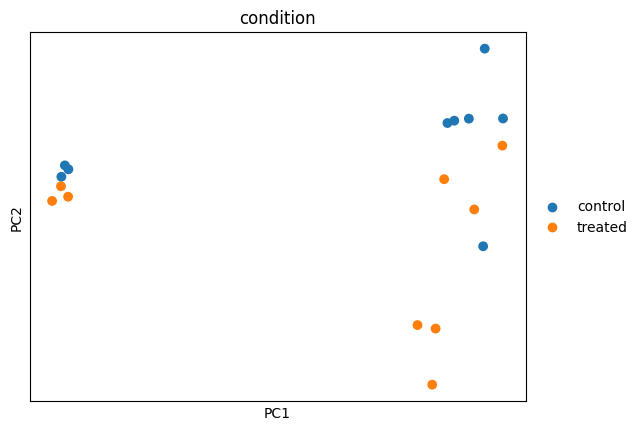

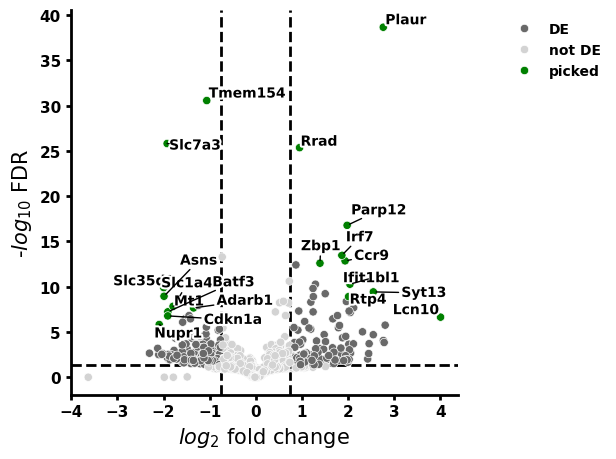

In [13]:
import scanpy as sc
import numpy as np
from sanbomics.plots import volcano
import seaborn as sns
import matplotlib.pyplot as plt  # Import matplotlib for plotting
counts_df = find_and_merge_count_files(gse_id)
group_label_mapping = get_group_label_mapping_from_gse(gse_id)
group_label_mapping
metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
metadata_df.index.name = "sample_geo_accession"
print(metadata_df)

counts_df.columns = [gsm if gsm in metadata_df.index else gsm for gsm in counts_df.columns]
valid_samples = metadata_df.index.intersection(counts_df.columns)
counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]
tcounts=counts_df.T

# Initialize DESeq2 dataset
inference = DefaultInference(n_cpus=4)
dds = DeseqDataSet(
    counts=tcounts,
    metadata=metadata_df,
    design_factors="condition",  # compare samples based on the "condition"
    refit_cooks=True,
    inference=inference,
)

# Fit DESeq2 model and perform differential expression analysis
dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
print(f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}")
dds.fit_MAP_dispersions()
dds.fit_LFC()
dds.calculate_cooks()
# Refit model if needed
if dds.refit_cooks:
    dds.refit()

# Summarize DESeq2 analysis results
stat_res = DeseqStats(dds, alpha=0.05, contrast=["condition", "treated", "control"],
                      cooks_filter=True, independent_filter=True)
stat_res.summary()
res = stat_res.results_df
table = stat_res.results_df
table.to_csv('deseq.csv')

stat_res.results_df
filtered_df = stat_res.results_df[
    (stat_res.results_df["padj"] < 0.05) &
    (stat_res.results_df["log2FoldChange"].abs() > 1)
].copy()
print(filtered_df.index.tolist())
# Perform additional analysis and visualization
dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1.5)]
dds_sigs = dds[:, sigs.index]

grapher = pd.DataFrame(
    dds_sigs.layers['log1p'],
    index=dds_sigs.obs_names,         # should be the sample names (GSMs)
    columns=dds_sigs.var_names        # should be gene names
).T                                   # transpose to get genes as rows, samples as columns

# Now, the first column will be sample names, and the index will be gene names
grapher.index.name = "gene"
grapher_cp=grapher.copy()


# Get the sample names
sample_names = list(dds_sigs.obs_names)

# Get treatment labels
sample_labels = [group_label_mapping[sample]["treatment"] for sample in sample_names]

# Combine sample name and label with underscore (e.g., 'GSM7757588_control')
labeled_columns = [f"{sample}_{label}" for sample, label in zip(sample_labels,sample_names)]

# Rename grapher columns
grapher.columns = labeled_columns


# Generate a clustermap of the selected genes
#sns.clustermap(grapher, z_score=18, cmap='RdYlBu_r',col_cluster=False,)

# Perform PCA and visualize the results
sc.tl.pca(dds)
#stat_res.lfc_shrink(coeff="condition_T_vs_C")
stat_res.lfc_shrink(coeff="condition[T.treated]")
sc.pl.pca(dds, color="condition", size=200)


# Create and display a volcano plot
res["symbol"] = res.index
volcano(res, symbol = 'symbol',log2fc='log2FoldChange',pval_thresh = 0.05,to_label = 10, 
           log2fc_thresh = 0.75,colors = ['dimgrey', 'lightgrey', 'green'],)
plt.show()


In [14]:
def annotate_clustermap_with_metadata(grapher, metadata_df):
    print("🔍 Starting clustermap annotation...")

    # 1. Build treatment label to GSM mapping
    label_map = {}
    for gsm, row in metadata_df.iterrows():
        label = str(row['treatment']).strip()
        if label not in label_map:
            label_map[label] = []
        label_map[label].append(gsm)
    print(f"✅ Built label_map with labels: {list(label_map.keys())}")

    # 2. Check if column names in grapher need remapping
    if not all(label in metadata_df.index for label in grapher.columns):
        print("⚠️ Column names in grapher are not pure GSM IDs. Attempting to remap based on treatment labels...")
        new_cols = []
        for label in grapher.columns:
            # Assume format: "Vehicle (DMSO)_GSM7757588"
            try:
                treatment_label = "_".join(label.split('_')[:-1])  # everything except last piece
            except Exception as e:
                raise ValueError(f"❌ Failed to parse treatment label from: {label} — {e}")

            matches = label_map.get(treatment_label)
            if not matches:
                raise ValueError(f"❌ No GSM match found for treatment label: {treatment_label} (from full label: {label})")
            new_cols.append(matches[0])  # Use only the first match
            print(f"🔄 Remapped {label} -> {matches[0]}")
        grapher.columns = new_cols
    else:
        print("✅ All grapher columns are valid GSM IDs")

    # 3. Extract annotations
    annotation_cols = ["condition", "treatment", "time"]
    missing_cols = [col for col in annotation_cols if col not in metadata_df.columns]
    if missing_cols:
        raise KeyError(f"❌ Metadata is missing required columns: {missing_cols}")

    try:
        col_annotation_df = metadata_df.loc[grapher.columns, annotation_cols].copy()
    except KeyError as e:
        raise KeyError(f"❌ Some GSM IDs in grapher not found in metadata: {e}")

    col_annotation_df = col_annotation_df.applymap(lambda x: str(x).strip() if pd.notna(x) else "NA")
    print("✅ Extracted column annotations.")

    # 4. Create annotation color maps
    col_colors = pd.DataFrame(index=col_annotation_df.index)
    palette_cache = {}

    palette_map = {
        "condition": "Set1",
        "treatment": "Dark2",
        "time": "Paired"
    }

    for col in annotation_cols:
        unique_vals = sorted(col_annotation_df[col].unique())
        real_vals = [v for v in unique_vals if v != "NA"]
        print(f"🎨 Mapping colors for {col}: {real_vals}")
        palette_name = palette_map.get(col, "Set2")
        palette = sns.color_palette(palette_name, len(real_vals))
        lut = dict(zip(real_vals, palette))
        lut["NA"] = "#ffffff"
        col_colors[col] = col_annotation_df[col].map(lut)
        palette_cache[col] = lut

    print("✅ Created color palettes for annotations.")

    # 5. Plot the clustermap
    print("📊 Generating clustermap...")
    g = sns.clustermap(
        grapher,
        z_score=0,
        cmap="RdYlBu_r",
        col_cluster=False,
        col_colors=col_colors
    )

    # 6. Add legend
    legend_handles = []
    for col, lut in palette_cache.items():
        for label, color in lut.items():
            legend_handles.append(Patch(facecolor=color, label=f"{col}: {label}"))

    plt.gcf().legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left", title="Annotations")
    plt.show()
    print("✅ Clustermap rendered successfully.")


🔍 Starting clustermap annotation...
✅ Built label_map with labels: ['Vehicle (DMSO)', 'PGE2']
✅ All grapher columns are valid GSM IDs
✅ Extracted column annotations.
🎨 Mapping colors for condition: ['control', 'treated']
🎨 Mapping colors for treatment: ['PGE2', 'Vehicle (DMSO)']
🎨 Mapping colors for time: ['24h', '48h', '60h']
✅ Created color palettes for annotations.
📊 Generating clustermap...


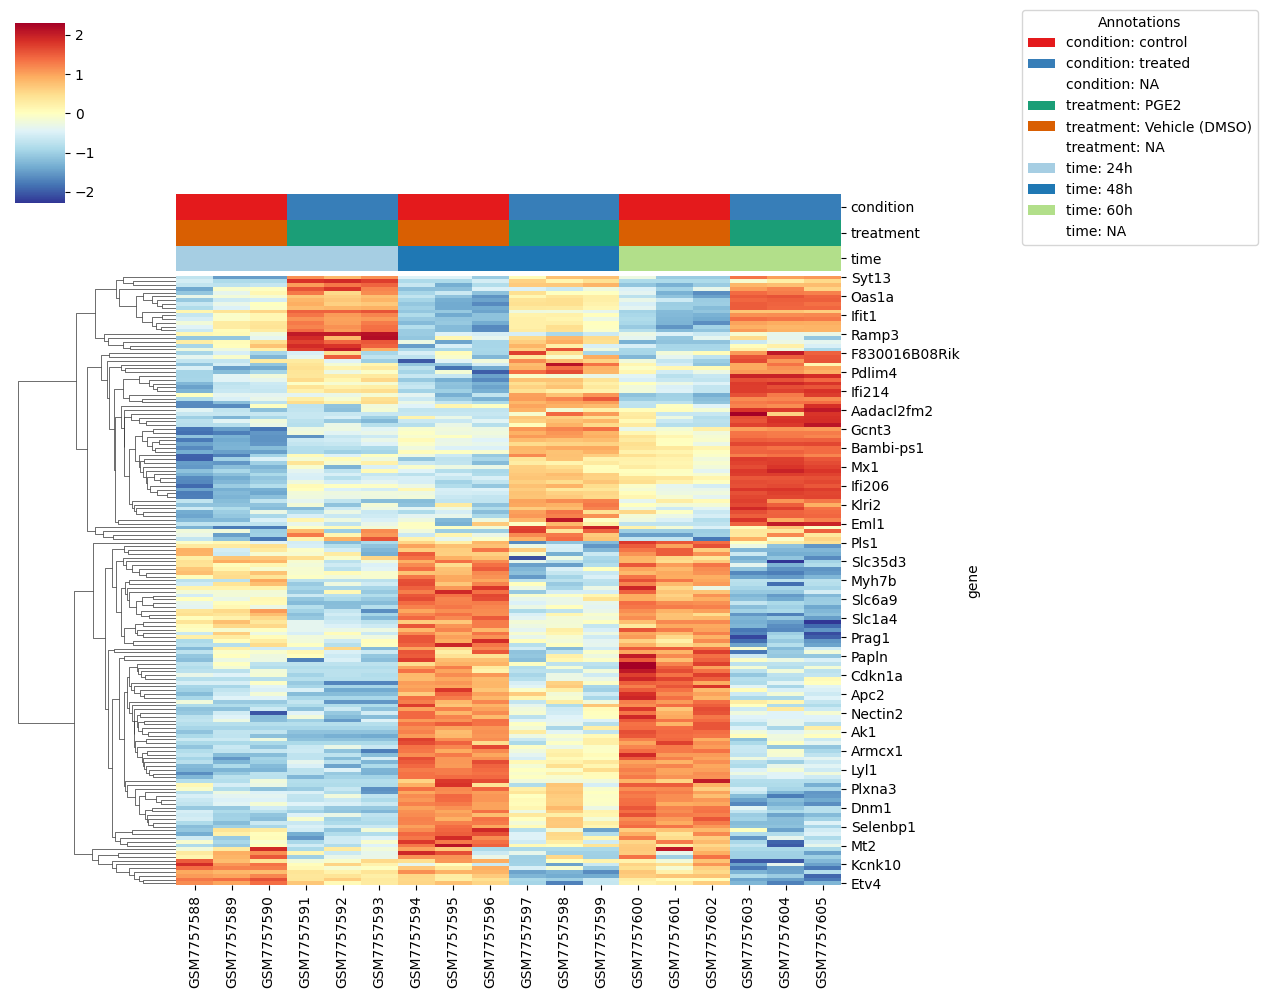

✅ Clustermap rendered successfully.


In [15]:
annotate_clustermap_with_metadata(grapher_cp, metadata_df)

In [ ]:
initial_state: Dict = {
    "query_gene": "",
    "pathway_info": {"genes": [], "drugs": [], "pathways": []},
    "metadata": {},
    "gse_list": [],
    "research_plan": "",
    "selected_gse": "GSE242272",
    "selected_gses": ["GSE242272"],
    "deg_results": {}
}
# Run the DEG analysis directly
result_state = run_deg_for_single_gse_debug(initial_state)

# Output the DEG results
print("\n✅ DEG Results by GSE ID:")
for gse_id, path in result_state.get("deg_results", {}).items():
    print(f"- {gse_id}: {path}")